In [1]:
import pandas as pd 
import numpy as np 
import os
import tensorflow as tf 
import matplotlib.pyplot as plt
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
#Read the CSV files to import the data
df_holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv', header = 0)
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv', header = 0)
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv', header = 0)
df_trans = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv', header = 0)

df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', header = 0)
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', header = 0)

In [3]:
df_train=df_train.set_index('id')
newdf = df_train.copy()
newdf['date'] = pd.to_datetime(newdf['date'])
newdf=newdf.groupby(['date', 'family'])[['sales', 'onpromotion']].sum().reset_index()
ndf=newdf.loc[newdf['family']=="POULTRY"]

<AxesSubplot:xlabel='date'>

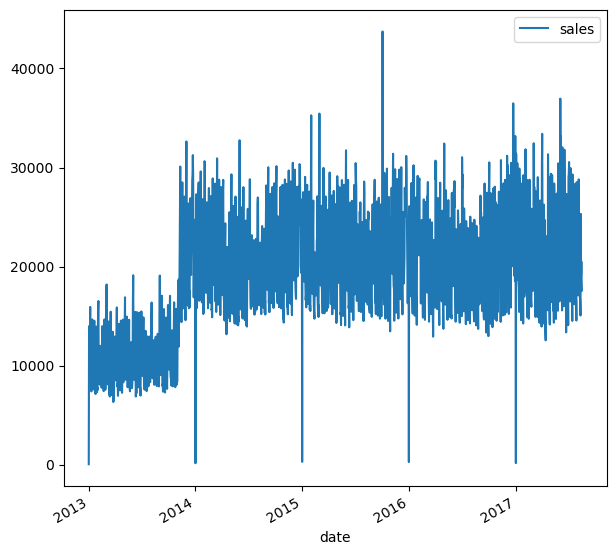

In [4]:
#Plots
ndf.plot(x='date', y='sales', kind='line', figsize=(7,7))

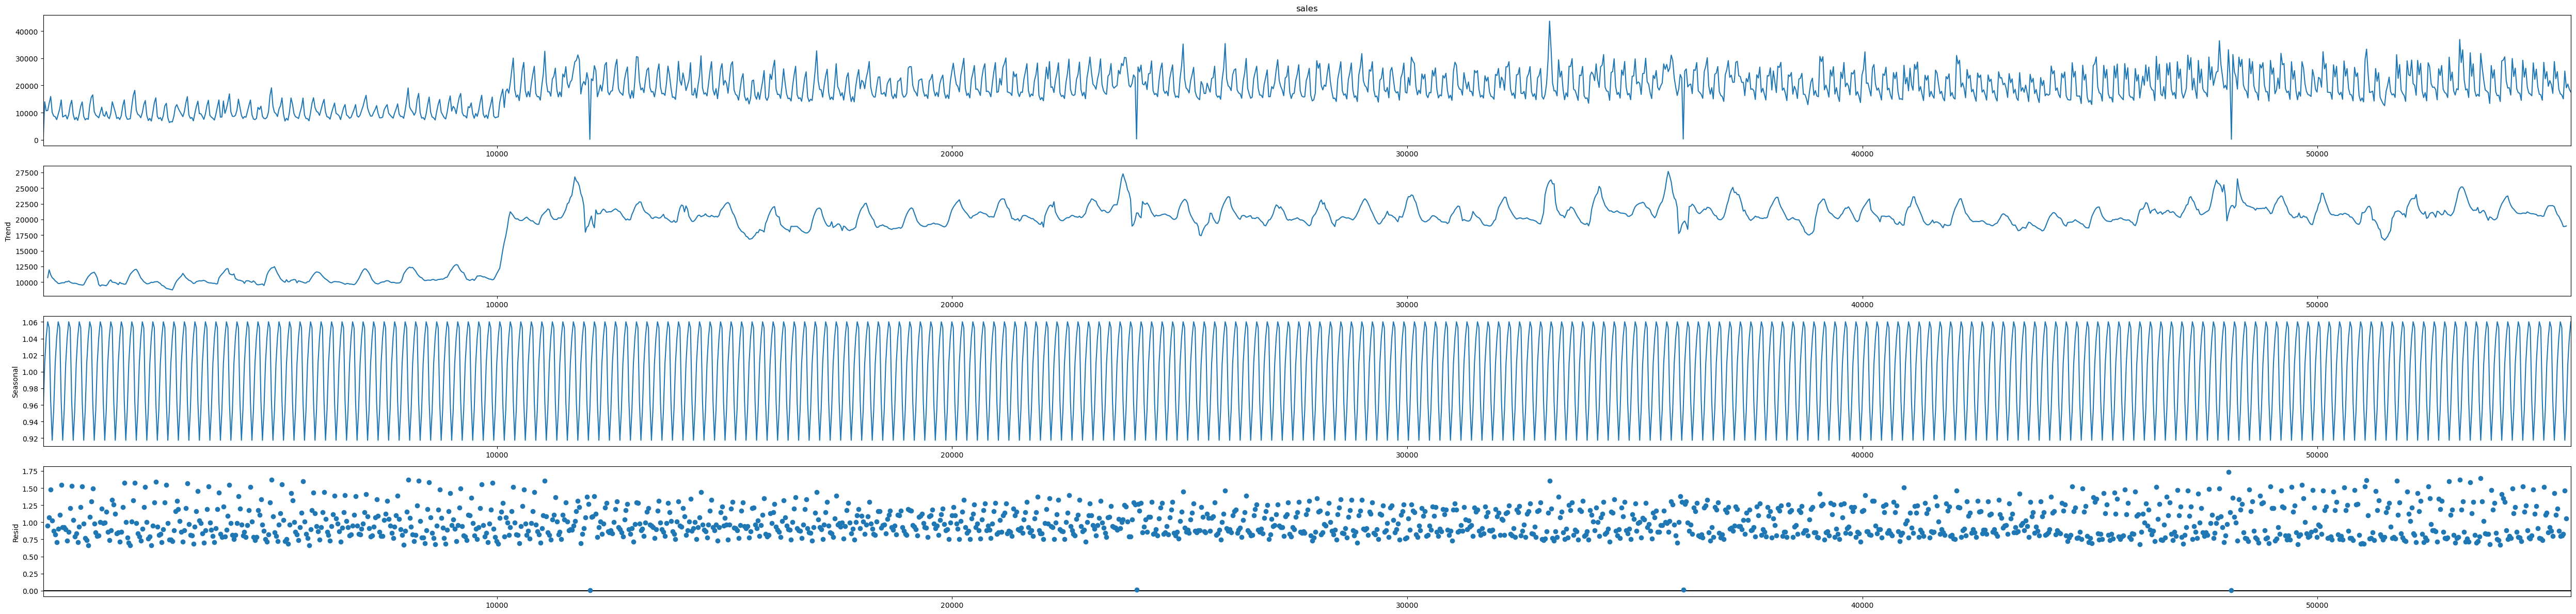

In [5]:
plt.rcParams["figure.figsize"] = (50,12)
result = seasonal_decompose(ndf['sales'], model='multiplicative', period = 7)
result.plot()
plt.show()

In [6]:
df_oil=df_oil.fillna(method='bfill')
df_oil['date'] = pd.to_datetime(df_oil['date'])

In [7]:
#Merge oil data to our dataframe
ndf = pd.merge(ndf, df_oil, on=['date'], how='left') 
ndf=ndf.fillna(method='bfill')
ndf = ndf.drop('family', axis=1)
ndf['sales'] = np.where(ndf['sales'] <1000, 0, ndf['sales'])
ndf['sales'].replace(0, np.nan, inplace=True)
ndf=ndf.fillna(method='bfill')

In [8]:
#Also incorporating holidays data
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')

holidays_df = holidays_df[holidays_df['transferred'] == False].copy()
holidays_df['holiday_type'] = holidays_df['type']
holidays_df.drop(['transferred', 'description', 'type'], axis=1, inplace=True)

national_holidays = holidays_df[holidays_df['locale'] == 'National'].copy()
national_holidays['national_holiday_type'] = national_holidays['holiday_type']
national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
national_holidays['date'] = pd.to_datetime(national_holidays['date'])
ndf = pd.merge(ndf, national_holidays, how='left', on=['date'])


del national_holidays


In [9]:
ndf

date         sales  onpromotion  dcoilwtico national_holiday_type
0    2013-01-01  13975.884938            0       93.14               Holiday
1    2013-01-02  13975.884938            0       93.14                   NaN
2    2013-01-03  10674.393983            0       92.97                   NaN
3    2013-01-04  10772.515038            0       93.12                   NaN
4    2013-01-05  13475.009055            0       93.20              Work Day
...         ...           ...          ...         ...                   ...
1679 2017-08-11  25318.297990         1480       48.81              Transfer
1680 2017-08-12  19134.510058            6       47.59                   NaN
1681 2017-08-13  20509.265004           10       47.59                   NaN
1682 2017-08-14  18597.508060            7       47.59                   NaN
1683 2017-08-15  17586.709986            6       47.57                   NaN

[1684 rows x 5 columns]

In [10]:
ndf.fillna('', inplace=True)

In [11]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(dtype=int)
ndf[['national_holiday_type']] = ordinal_encoder.fit_transform(ndf[['national_holiday_type']])

In [12]:
ndf['date'] = pd.to_datetime(ndf['date'])

In [13]:
ndf = ndf.set_index('date')

In [14]:
ndf['dayofweek'] = ndf.index.dayofweek
ndf['quarter'] = ndf.index.quarter
ndf['month'] = ndf.index.month
ndf['year'] = ndf.index.year
ndf['dayofyear'] = ndf.index.dayofyear

In [15]:
ndf=ndf.reset_index()
ndf.rename(columns={'index': 'date'}, inplace=True)
ndf


date         sales  onpromotion  dcoilwtico  national_holiday_type  \
0    2013-01-01  13975.884938            0       93.14                      4   
1    2013-01-02  13975.884938            0       93.14                      0   
2    2013-01-03  10674.393983            0       92.97                      0   
3    2013-01-04  10772.515038            0       93.12                      0   
4    2013-01-05  13475.009055            0       93.20                      6   
...         ...           ...          ...         ...                    ...   
1679 2017-08-11  25318.297990         1480       48.81                      5   
1680 2017-08-12  19134.510058            6       47.59                      0   
1681 2017-08-13  20509.265004           10       47.59                      0   
1682 2017-08-14  18597.508060            7       47.59                      0   
1683 2017-08-15  17586.709986            6       47.57                      0   

      dayofweek  quarter  month  year  dayofyear  
0             1        1      1  2013          1  
1             2        1      1  2013          2  
2             3        1      1  2013          3  
3             4        1      1  2013          4  
4             5        1      1  2013          5  
...         ...      ...    ...   ...        ...  
1679          4        3      8  2017        223  
1680          5        3      8  2017        224  
1681          6        3      8  2017        225  
1682          0        3      8  2017        226  
1683          1        3      8  2017        227  

[1684 rows x 10 columns]

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


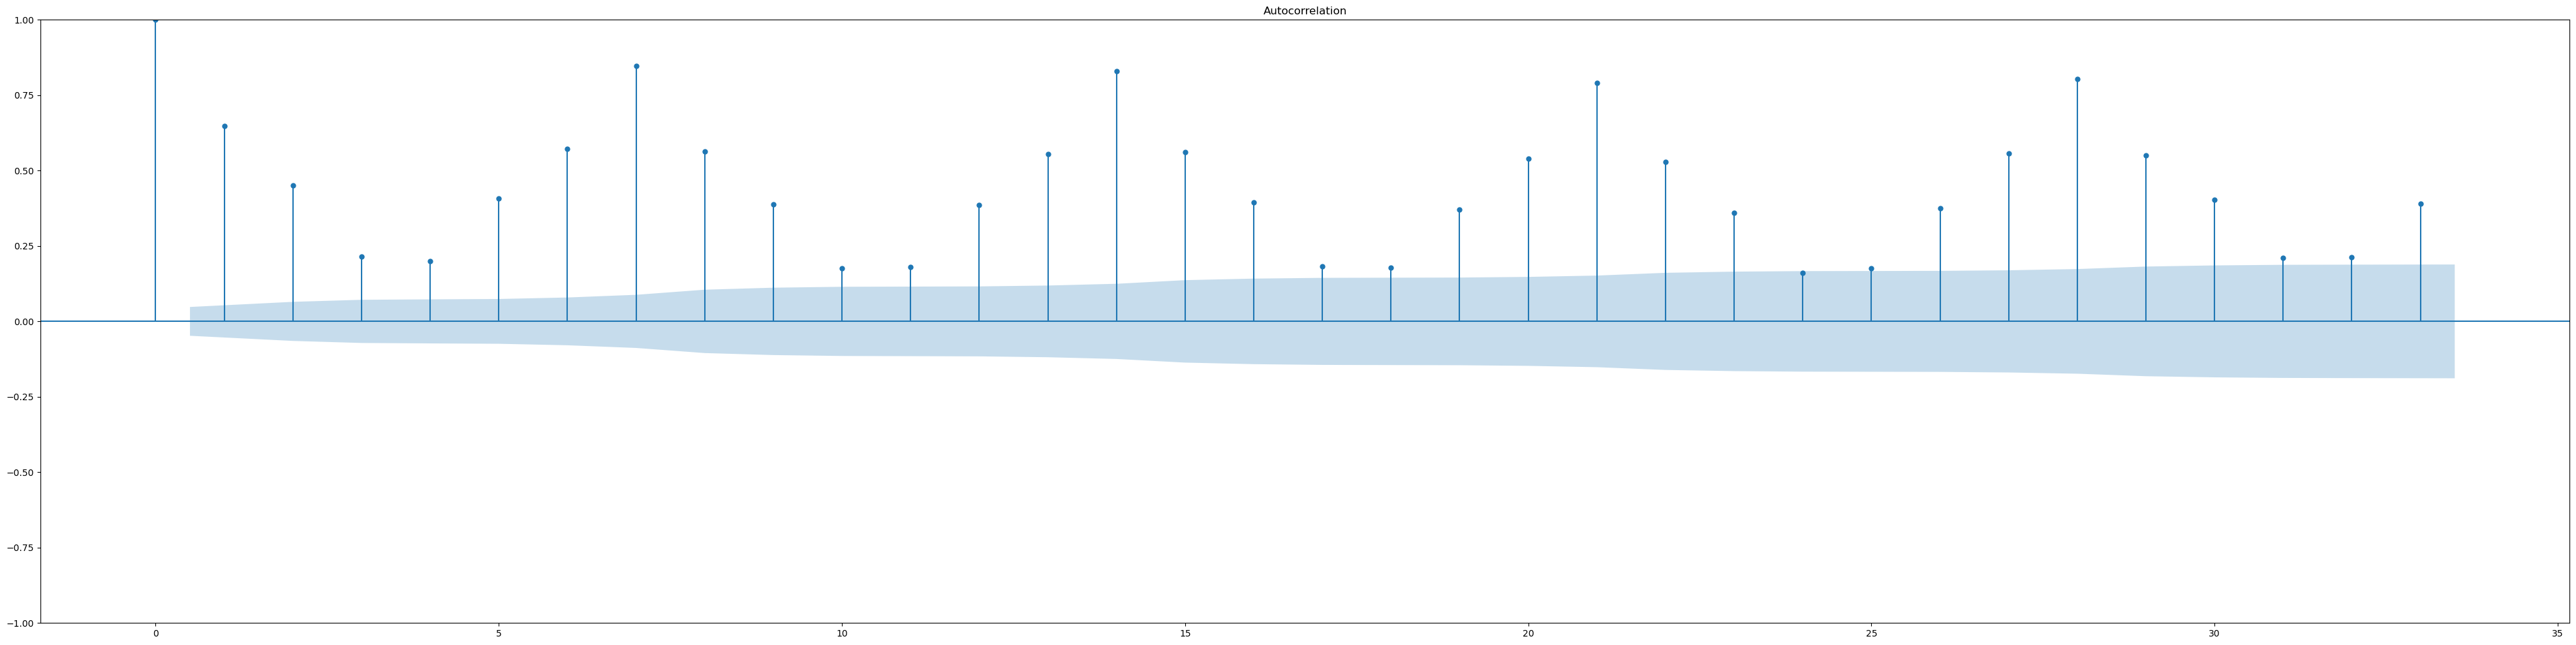

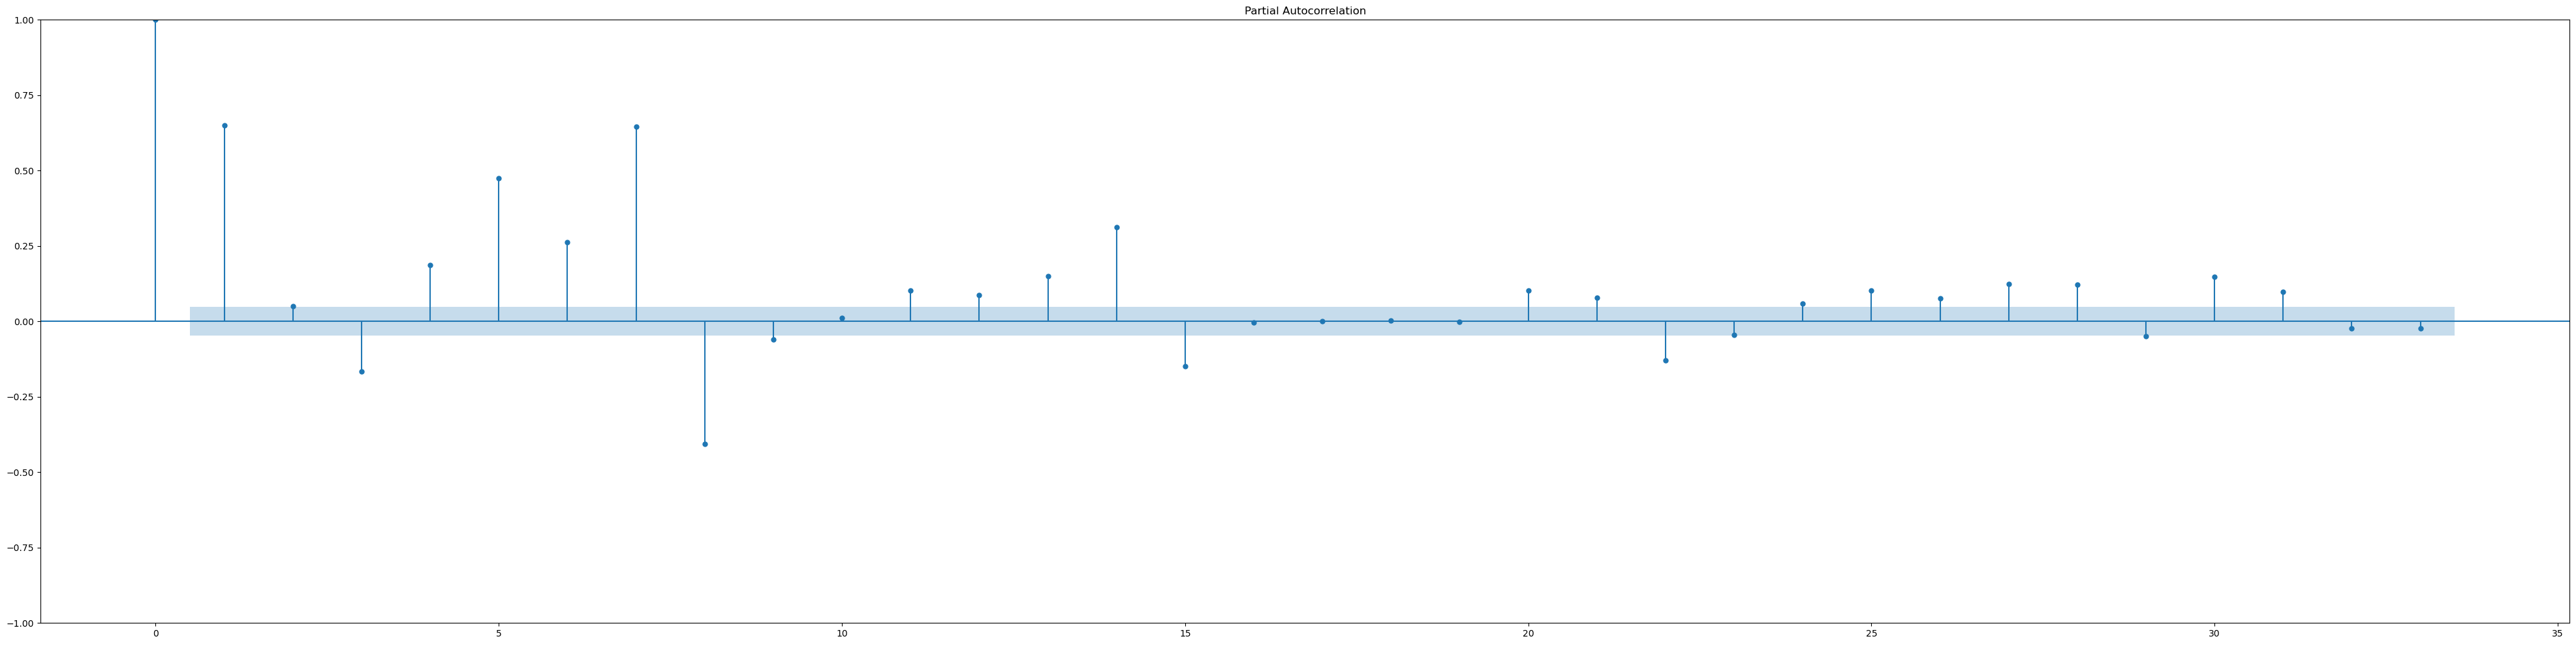

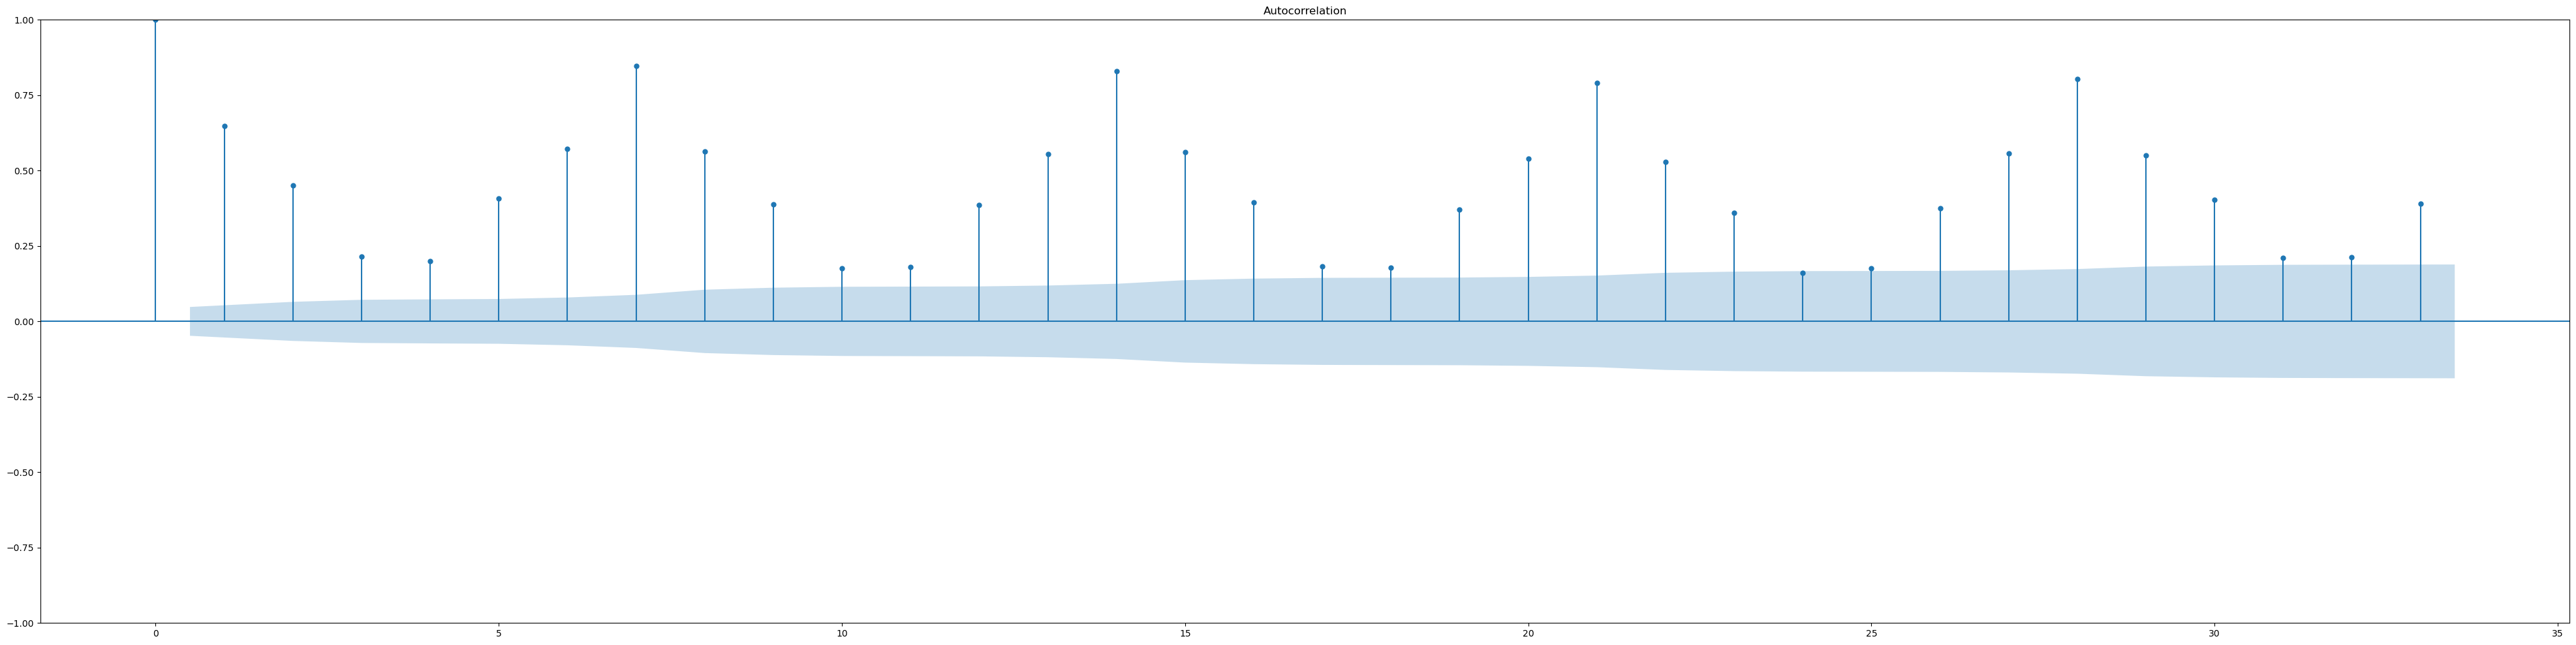

In [16]:
plot_pacf(ndf['sales'])
plot_acf(ndf['sales'])

In [17]:
# ADF Test before log differencing
ad_fuller_result = adfuller(ndf['sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.423203535013838
p-value: 0.1352941873173153


In [18]:
ndf1=ndf.copy()
ndf1['sales'] = np.log(ndf1['sales'])
ndf1['sales'] = ndf1['sales'].diff(7)
ndf1 = ndf1.drop(ndf1.index[0])

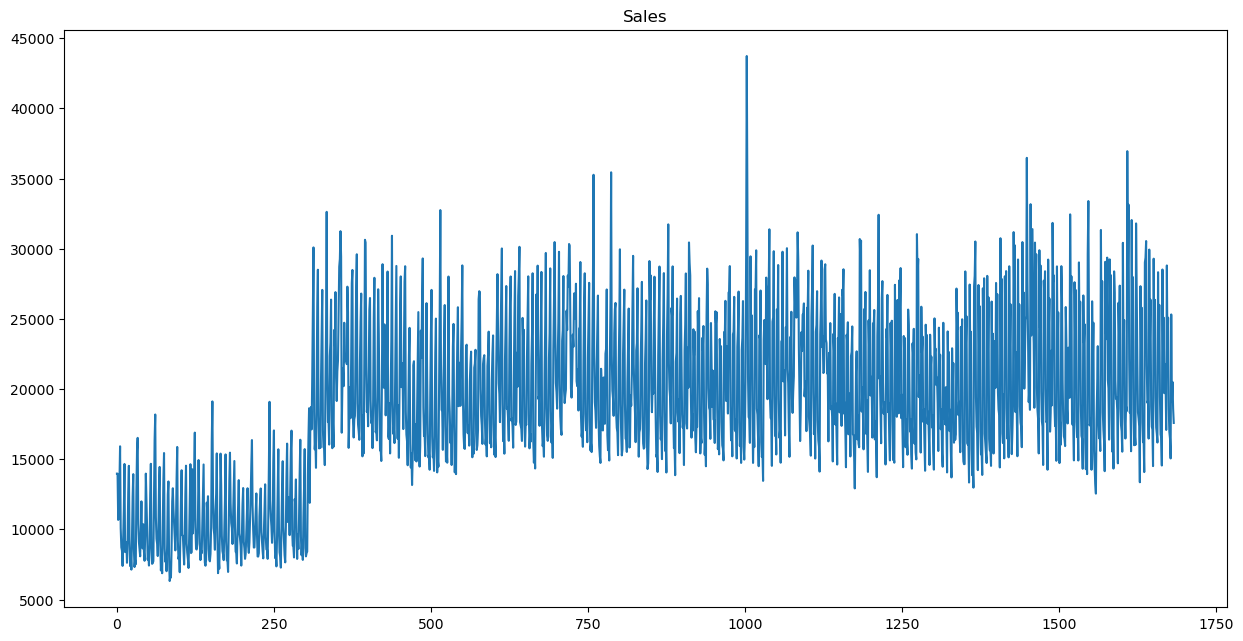

In [19]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(ndf['sales'])
plt.title("Sales")                          #Original plot
plt.show()

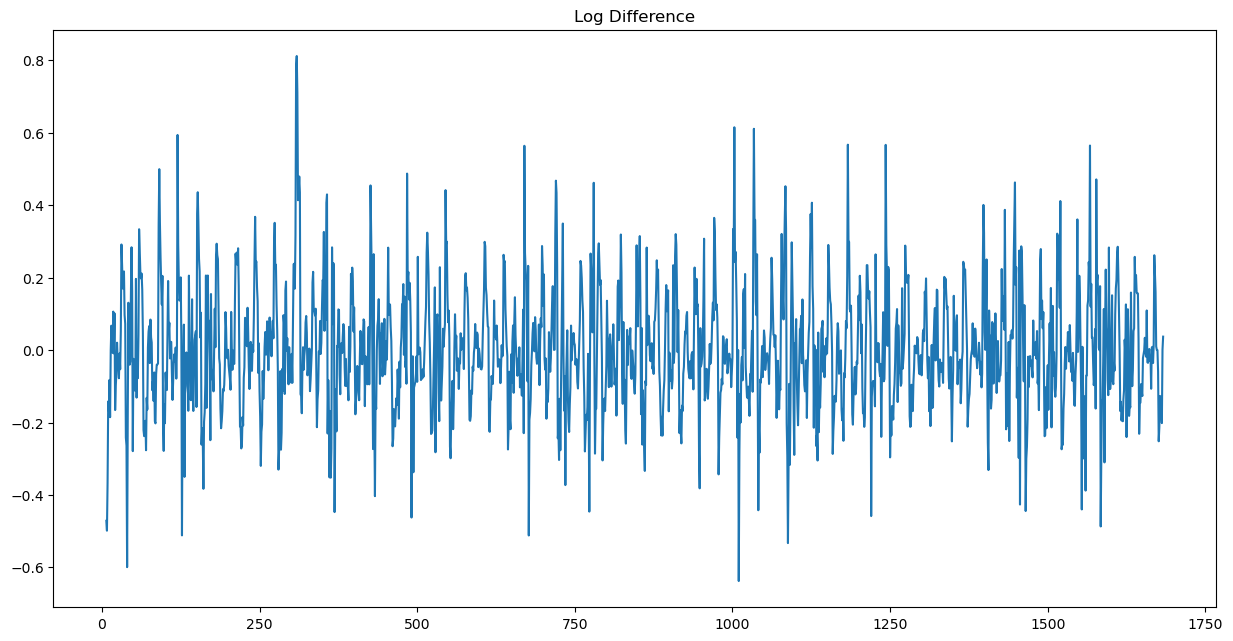

In [20]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(ndf1['sales'])
plt.title("Log Difference")
plt.show()

In [21]:
# ADF test after log differencing
ndf1=ndf1.dropna()
ad_fuller_result = adfuller(ndf1['sales'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -15.142806996147565
p-value: 6.972022187682759e-28


/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


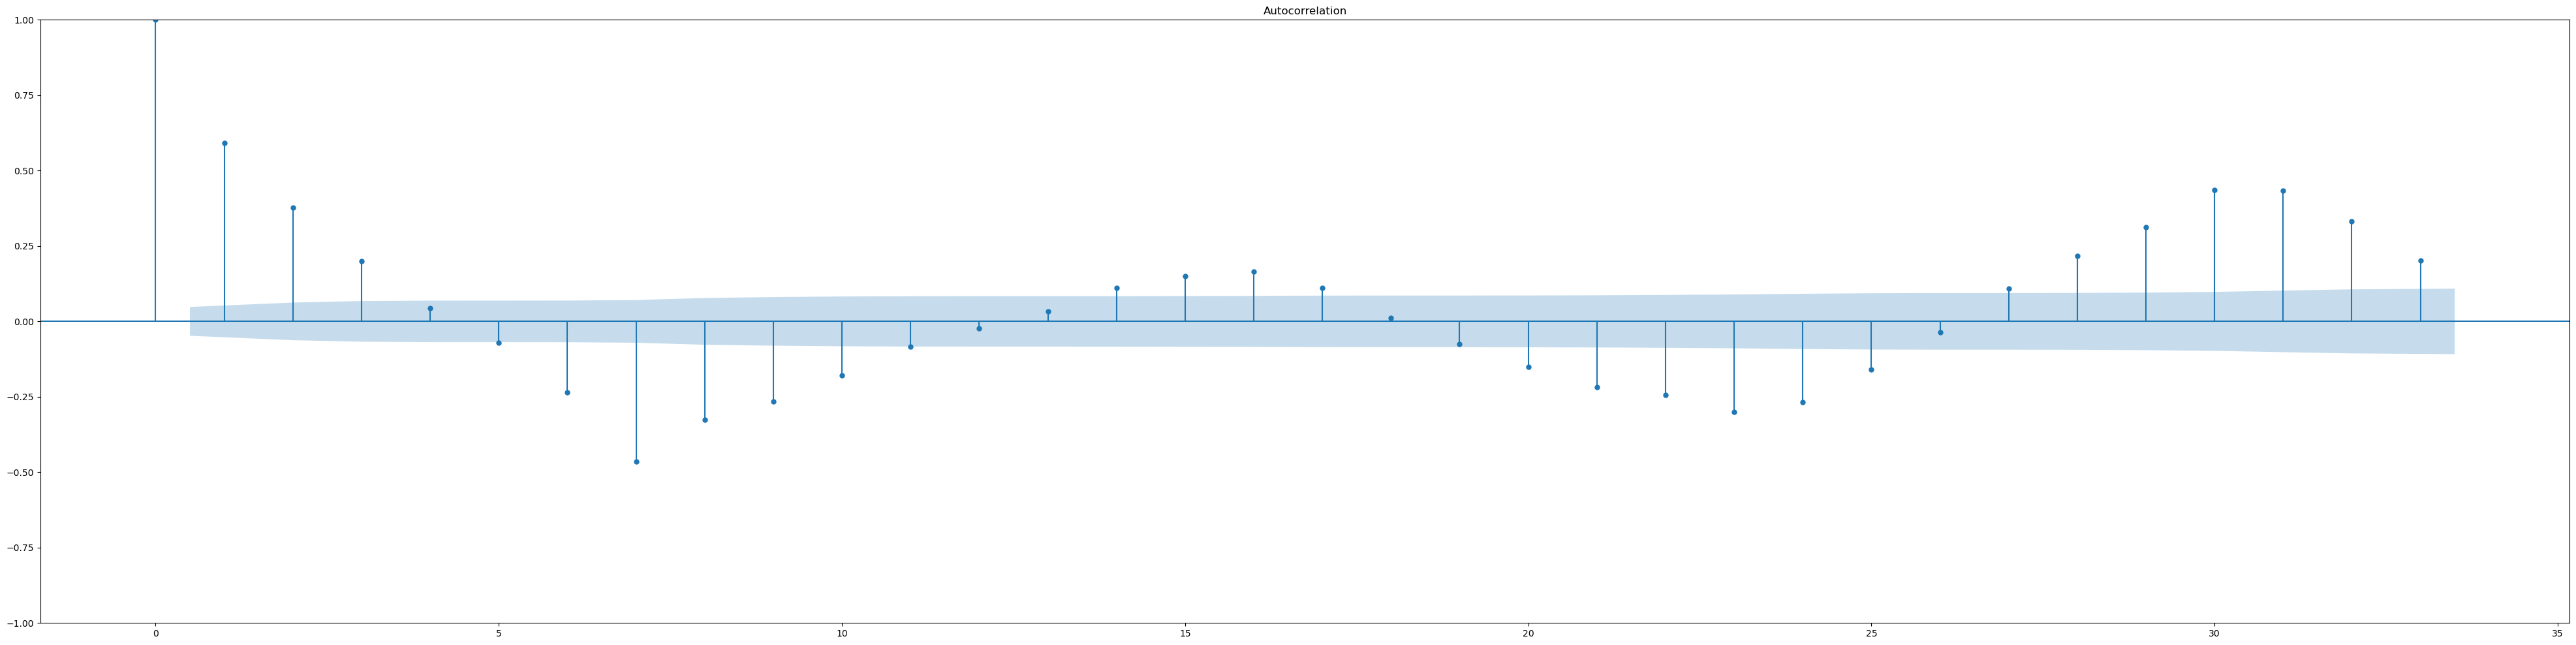

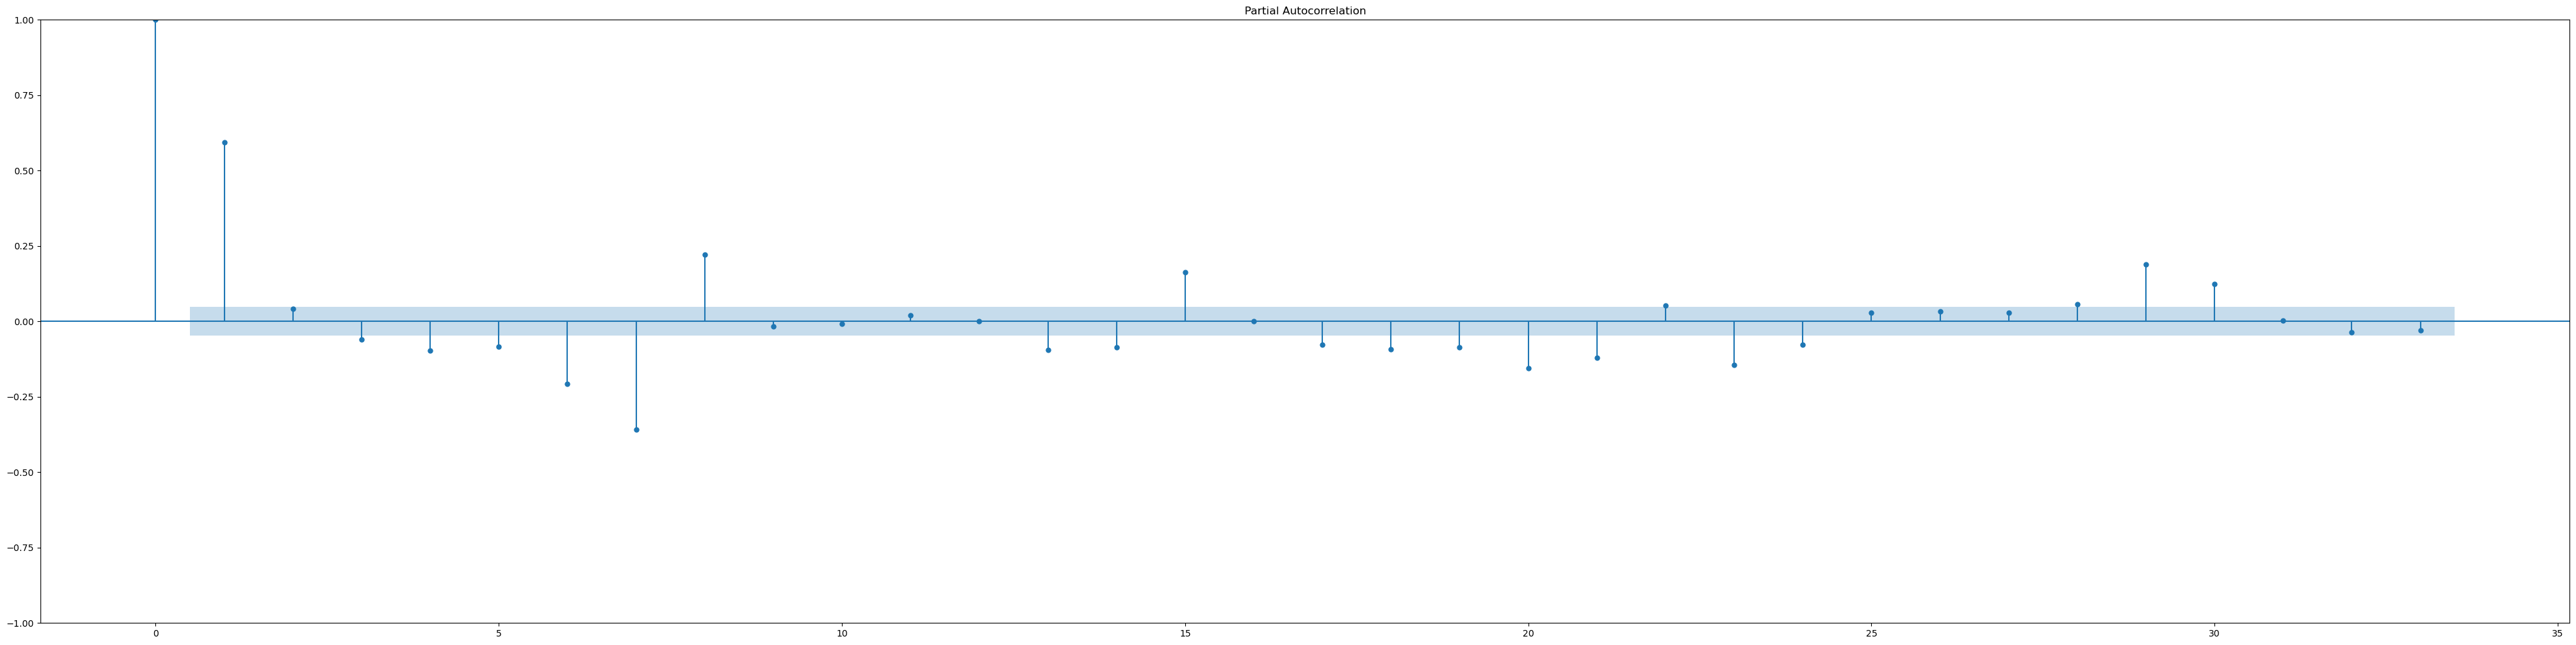

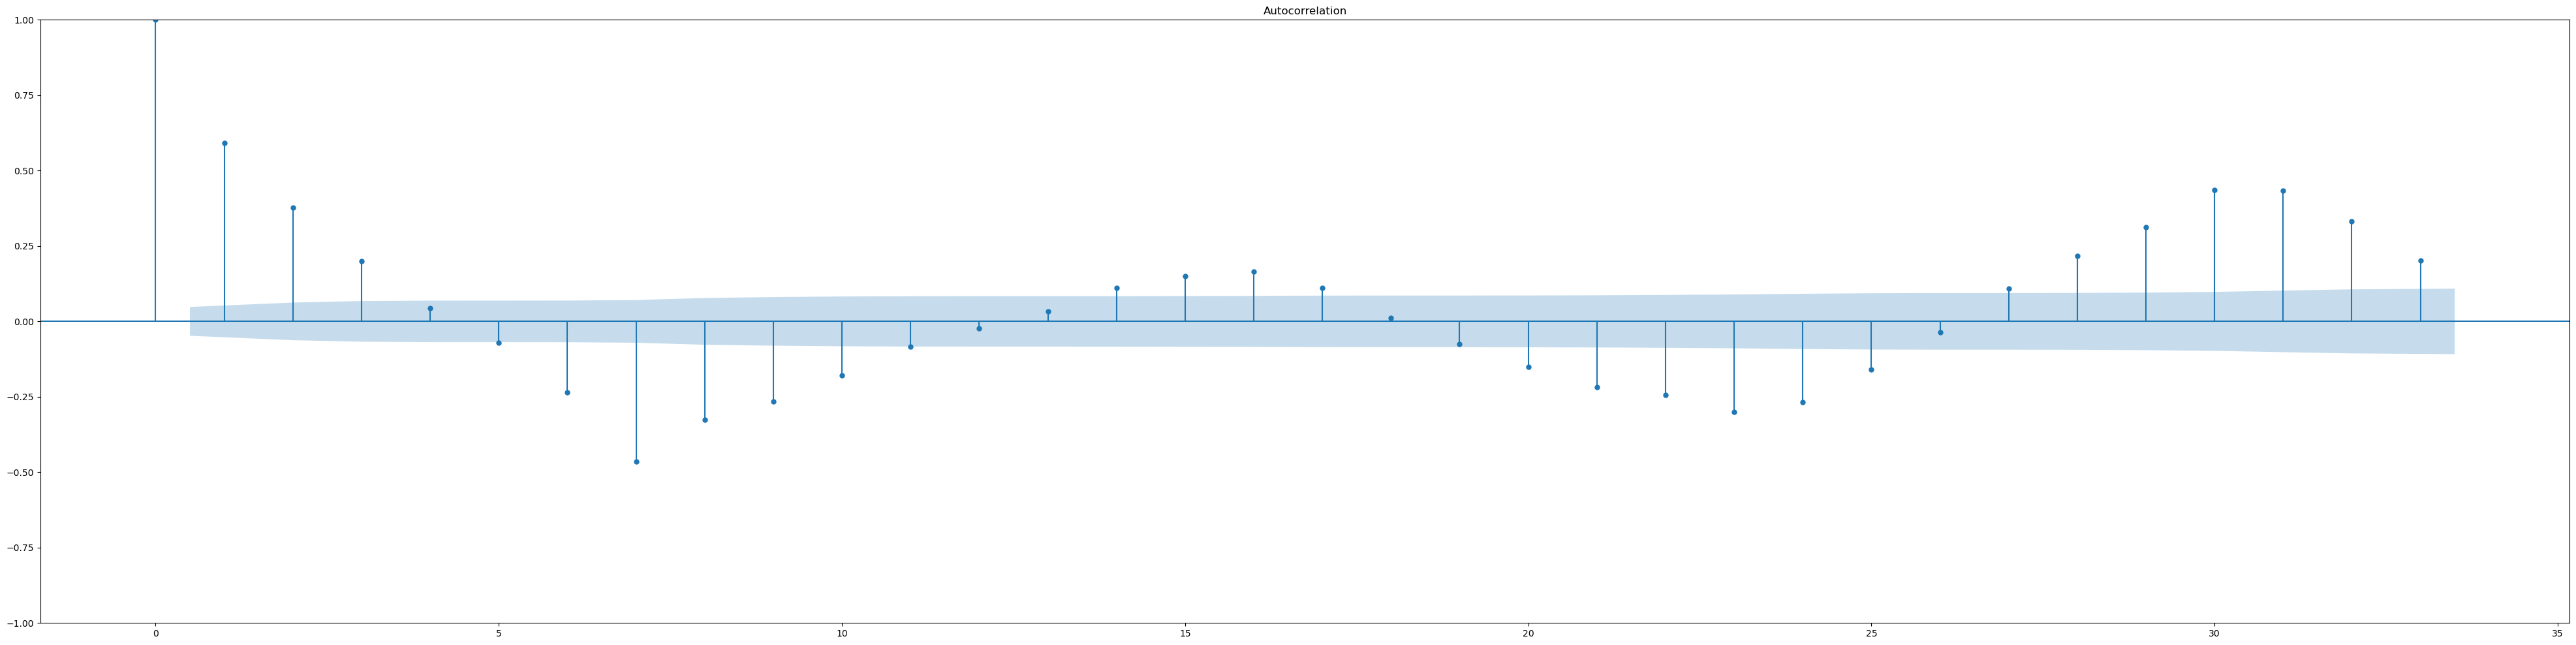

In [22]:
#Plot the Autocorellation graphs
plot_pacf(ndf1['sales'])
plot_acf(ndf1['sales'])

In [23]:
#Prepare train data for SARIMAX model
train_size = int(len(ndf) * 0.8)
train_data, test_data = ndf[:train_size], ndf[train_size:]
train_data = train_data.set_index(['date'])
test_data = test_data.set_index(['date'])


s = train_data
idx = pd.date_range('01-01-2013', '09-11-2016')
s = s.reindex(idx, fill_value=0)

s1 = test_data
idx = pd.date_range('9-12-2016', '08-15-2017')
s1 = s1.reindex(idx, fill_value=0)

In [24]:
s['sales'].replace(0, np.nan, inplace=True)
s=s.fillna(method='bfill')

s1['sales'].replace(0, np.nan, inplace=True)
s1=s1.fillna(method='bfill')

In [25]:
#Train the SARIMA model
mod = SARIMAX(s['sales'], exog = s[['onpromotion','dcoilwtico','national_holiday_type','dayofweek','quarter','month','year','dayofyear']], order=(1, 1, 1), seasonal_order=(3, 1, 1, 7), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit(disp = 0)
print(results.summary().tables[1])

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
onpromotion               2.5029      1.318      1.899      0.058      -0.081       5.086
dcoilwtico               90.3526     39.431      2.291      0.022      13.068     167.637
national_holiday_type   166.6699     68.615      2.429      0.015      32.187     301.153
dayofweek              1318.8163    804.500      1.639      0.101    -257.975    2895.608
quarter                1260.2656    811.601      1.553      0.120    -330.442    2850.974
month                  3638.2517    462.187      7.872      0.000    2732.381    4544.122
year                     -4.6178      2.201     -2.098      0.036      -8.931      -0.305
dayofyear              -127.2404     13.940     -9.128      0.000    -154.562     -99.919
ar.L1                     0.5257      0.034     15.517      0.000       0.459       0.592
ma.L1     

<AxesSubplot:>

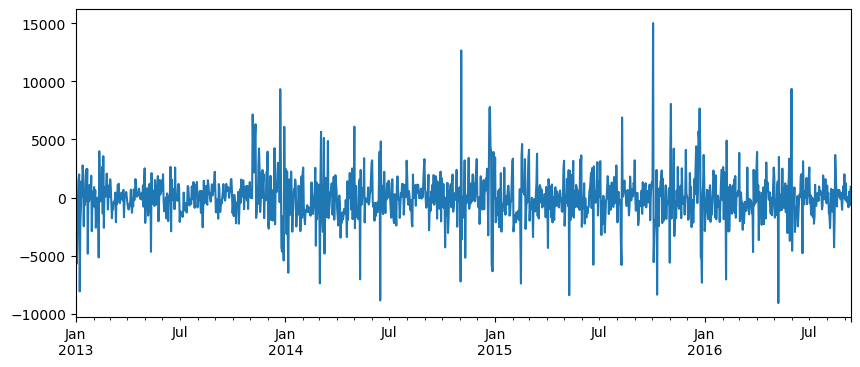

In [26]:
#Residuals plot
residuals = results.resid
residuals.plot(figsize=(10,4))

<AxesSubplot:>

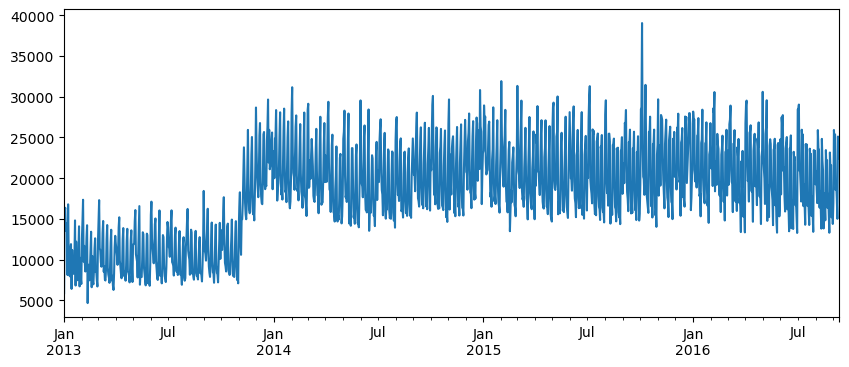

In [27]:
predictions=results.predict()
predictions.plot(figsize=(10,4))

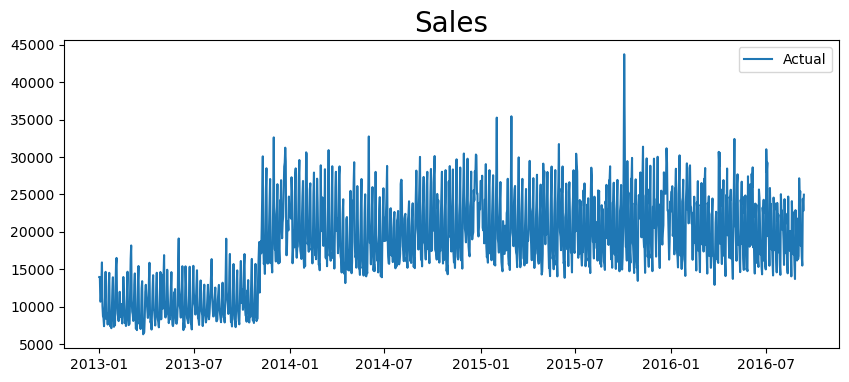

In [28]:
plt.figure(figsize=(10,4))
plt.plot(s['sales'], label="Actual")
plt.title('Sales', fontsize=20)
plt.legend()

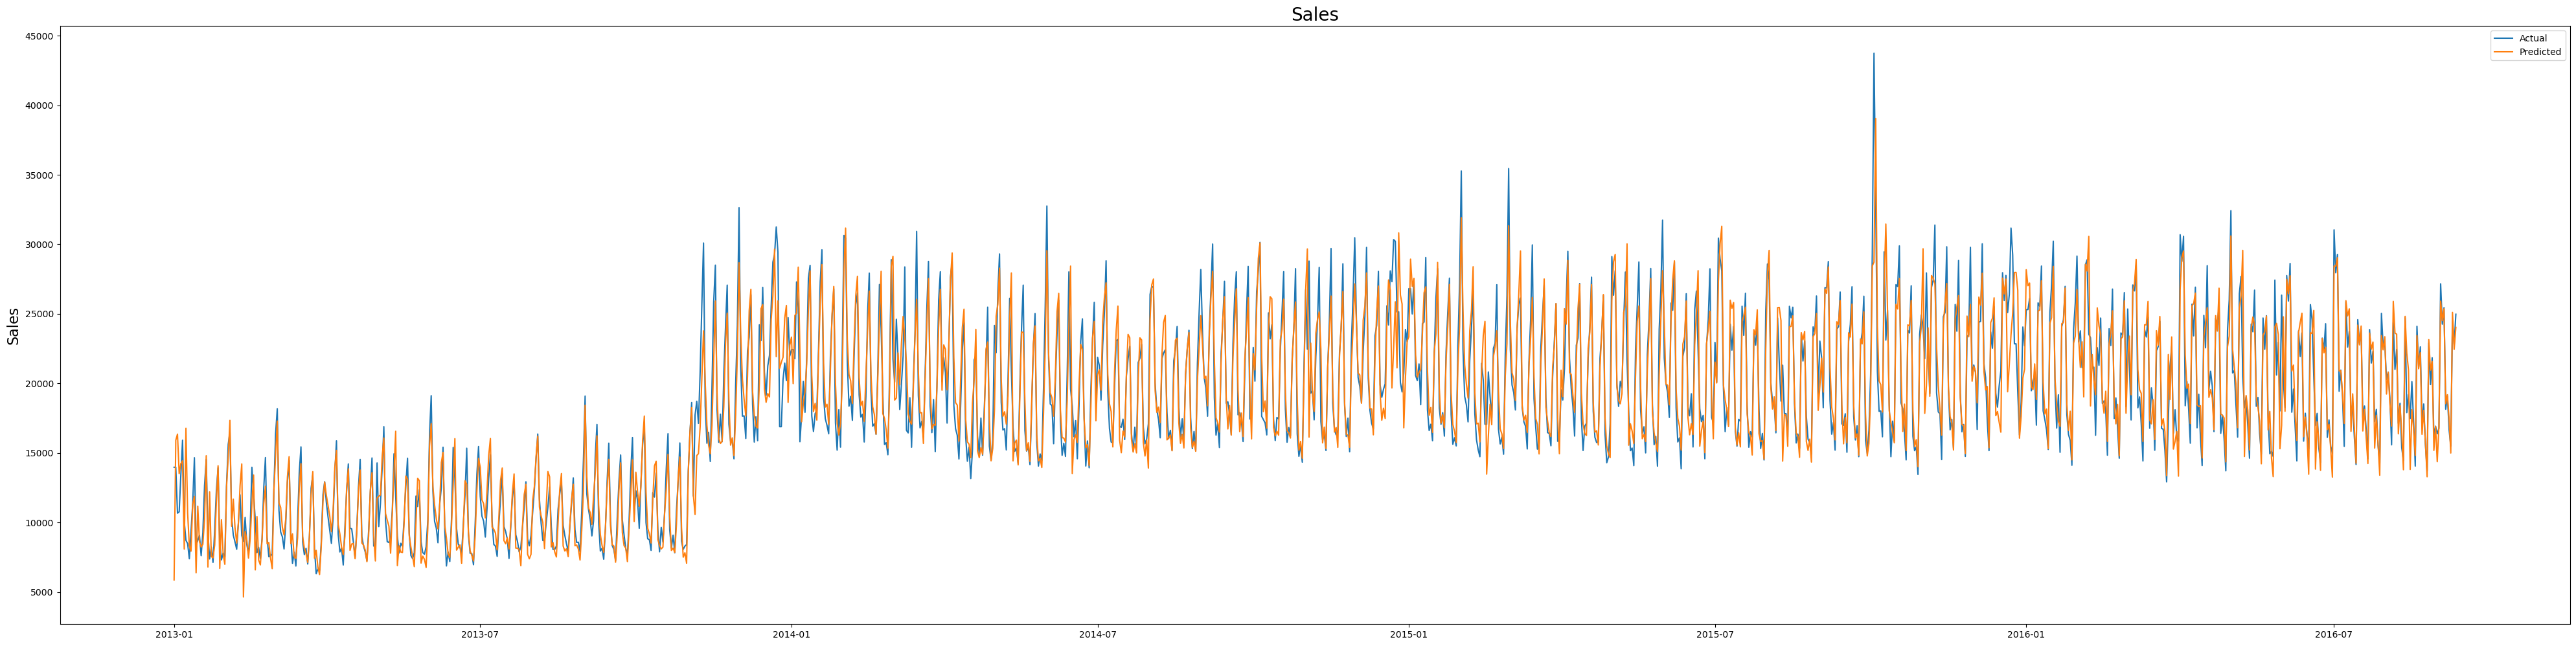

In [29]:
#Predictions plot over training data
plt.figure(figsize=(50,12))
plt.plot(s['sales'], label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [30]:
predict_dy = results.get_prediction(start = '09-12-2016', end = '08-15-2017', exog=s1[['onpromotion','dcoilwtico','national_holiday_type','dayofweek','quarter','month','year','dayofyear']], dynamic= False)
predict_dy_ci = predict_dy.conf_int()

print(predict_dy_ci)

             lower sales   upper sales
2016-09-12  12669.442053  22861.632407
2016-09-13  12620.439594  24481.298366
2016-09-14   9871.525727  22356.265514
2016-09-15   7775.504719  20561.052045
2016-09-16  17098.865433  30065.201316
...                  ...           ...
2017-08-11 -24156.869609  70950.090584
2017-08-12 -27892.781718  67522.981352
2017-08-13 -26683.042932  69039.376502
2017-08-14 -33549.838350  62551.249908
2017-08-15 -32606.645748  63840.665385

[338 rows x 2 columns]


<AxesSubplot:>

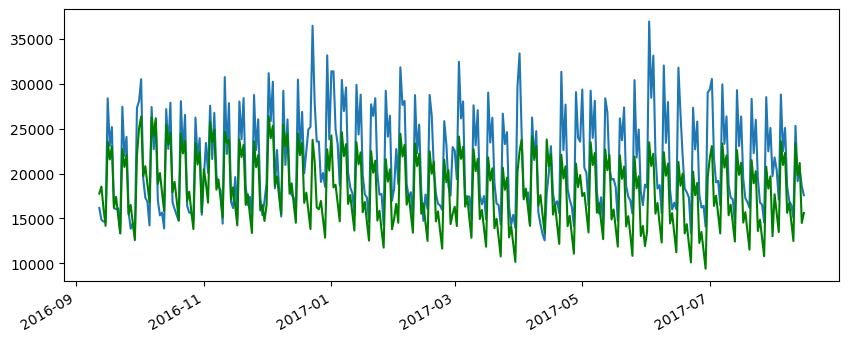

In [31]:
plt.figure(figsize=(10,4))
plt.plot(s1['sales'], label="Actual")
predict_dy.predicted_mean.loc['09-12-2016':].plot(style='g', label='forecast')

<AxesSubplot:>

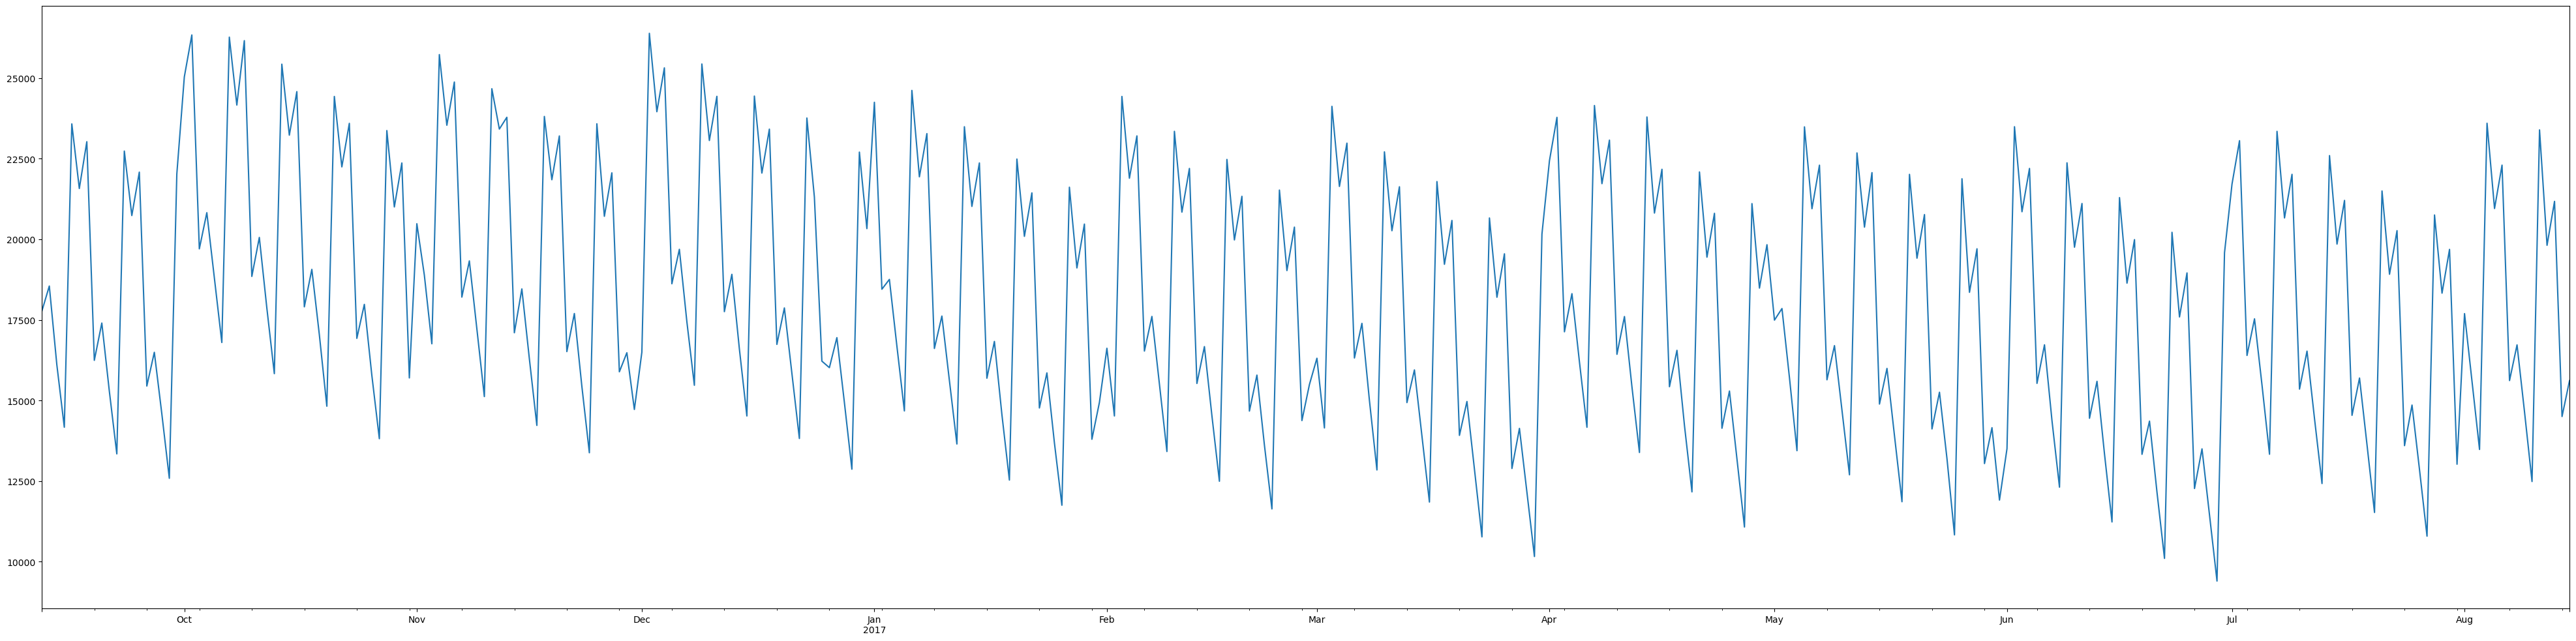

In [32]:
predictions_test=results.predict(start = '09-12-2016', end = '08-15-2017', exog=s1[['onpromotion','dcoilwtico','national_holiday_type','dayofweek','quarter','month','year','dayofyear']], dynamic= True)
predictions_test.plot(figsize=(50,12))

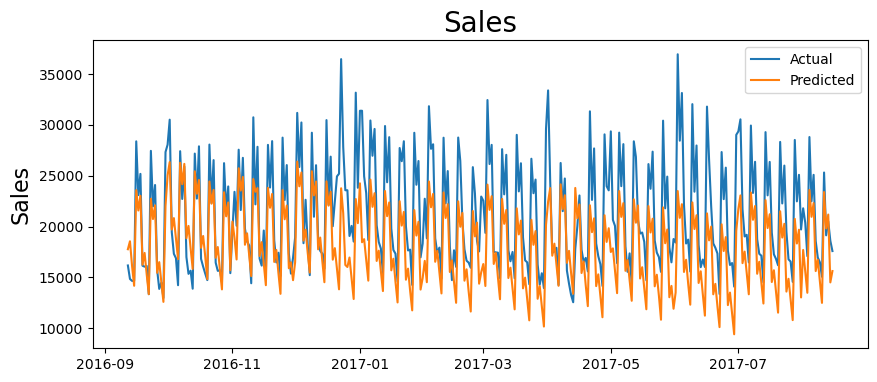

In [33]:
#Predictions plot over test data

plt.figure(figsize=(10,4))
plt.plot(s1['sales'], label="Actual")
plt.plot(predictions_test, label="Predicted")
plt.title('Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()

In [34]:
from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error( s['sales'], predictions))
rmsle

0.1077421876298464

In [35]:
from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error( s1['sales'], predictions_test ))
rmsle

0.21362942864710913

In [36]:
#RMSE on train data
from sklearn import metrics   
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(s['sales'], predictions))) 

Root Mean Squared Error: 1992.8610949008862


In [37]:
#RMSE on test data
from sklearn import metrics  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(s1['sales'], predictions_test))) 

Root Mean Squared Error: 4446.096423484205


In [38]:
residuals_pred = predictions_test - s1['sales']

In [39]:
residuals_pred

2016-09-12    1598.234238
2016-09-13    3710.369060
2016-09-14    1467.194626
2016-09-15    -489.931618
2016-09-16   -4803.129625
                 ...     
2017-08-11   -1921.687503
2017-08-12     680.589759
2017-08-13     668.901781
2017-08-14   -4096.802281
2017-08-15   -1969.700168
Freq: D, Length: 338, dtype: float64

# LSTM

In [40]:
residuals1=pd.DataFrame(residuals)
residuals1=residuals1.reset_index()
residuals1.columns =['date', 'sales']
s=s.reset_index()
s.rename(columns={'index': 'date'}, inplace=True)
s['residuals']=residuals1['sales']


In [41]:
residuals_pred=pd.DataFrame(residuals)
residuals_pred=residuals_pred.reset_index()
residuals_pred.columns =['date', 'sales']
s1=s1.reset_index()
s1.rename(columns={'index': 'date'}, inplace=True)
s1['residuals']=residuals_pred['sales']

In [42]:
s3 = s[['date','sales','onpromotion','national_holiday_type','dayofweek','quarter','month','year','dayofyear', 'dcoilwtico','residuals']]

In [43]:
s4 = s1[['date','sales','onpromotion','national_holiday_type','dayofweek','quarter','month','year','dayofyear', 'dcoilwtico','residuals']]

In [44]:
cols = list(s3)[1:]
print(cols)

['sales', 'onpromotion', 'national_holiday_type', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dcoilwtico', 'residuals']


In [45]:
df_for_training = s3[cols].astype(float)

In [46]:
#Standar Scalar preprocessing

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [47]:
#Training on 7 days in past and making a prediction 1 day in future

trainX = []
trainY = []

n_future = 1  
n_past = 7 

#shape: (num_samples x timesteps x n_features)

for i in range(n_past, len(df_for_training_scaled) ):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1343, 7, 10).
trainY shape == (1343, 1).


In [298]:
# Model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 7, 64)             19200     
                                                                 
 lstm_24 (LSTM)              (None, 7, 32)             12416     
                                                                 
 dropout_15 (Dropout)        (None, 7, 32)             0         
                                                                 
 lstm_25 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 34,769
Trainable params: 34,769
Non-trai

In [299]:
# model fitting
history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 49ms/step - loss: 0.9942 - val_loss: 0.6037
Epoch 2/100
17/17 [==============================] - 0s 17ms/step - loss: 0.6435 - val_loss: 0.4911
Epoch 3/100
17/17 [==============================] - 0s 17ms/step - loss: 0.4967 - val_loss: 0.4611
Epoch 4/100
17/17 [==============================] - 0s 17ms/step - loss: 0.4186 - val_loss: 0.4094
Epoch 5/100
17/17 [==============================] - 0s 17ms/step - loss: 0.3528 - val_loss: 0.3744
Epoch 6/100
17/17 [==============================] - 0s 17ms/step - loss: 0.2793 - val_loss: 0.3461
Epoch 7/100
17/17 [==============================] - 0s 17ms/step - loss: 0.2748 - val_loss: 0.3852
Epoch 8/100
17/17 [==============================] - 0s 18ms/step - loss: 0.2400 - val_loss: 0.3428
Epoch 9/100
17/17 [==============================] - 0s 17ms/step - loss: 0.2173 - val_loss: 0.3226
Epoch 10/100
17/17 [==============================] - 0s 17ms/step - loss: 0.2162 - val_loss: 0.3003

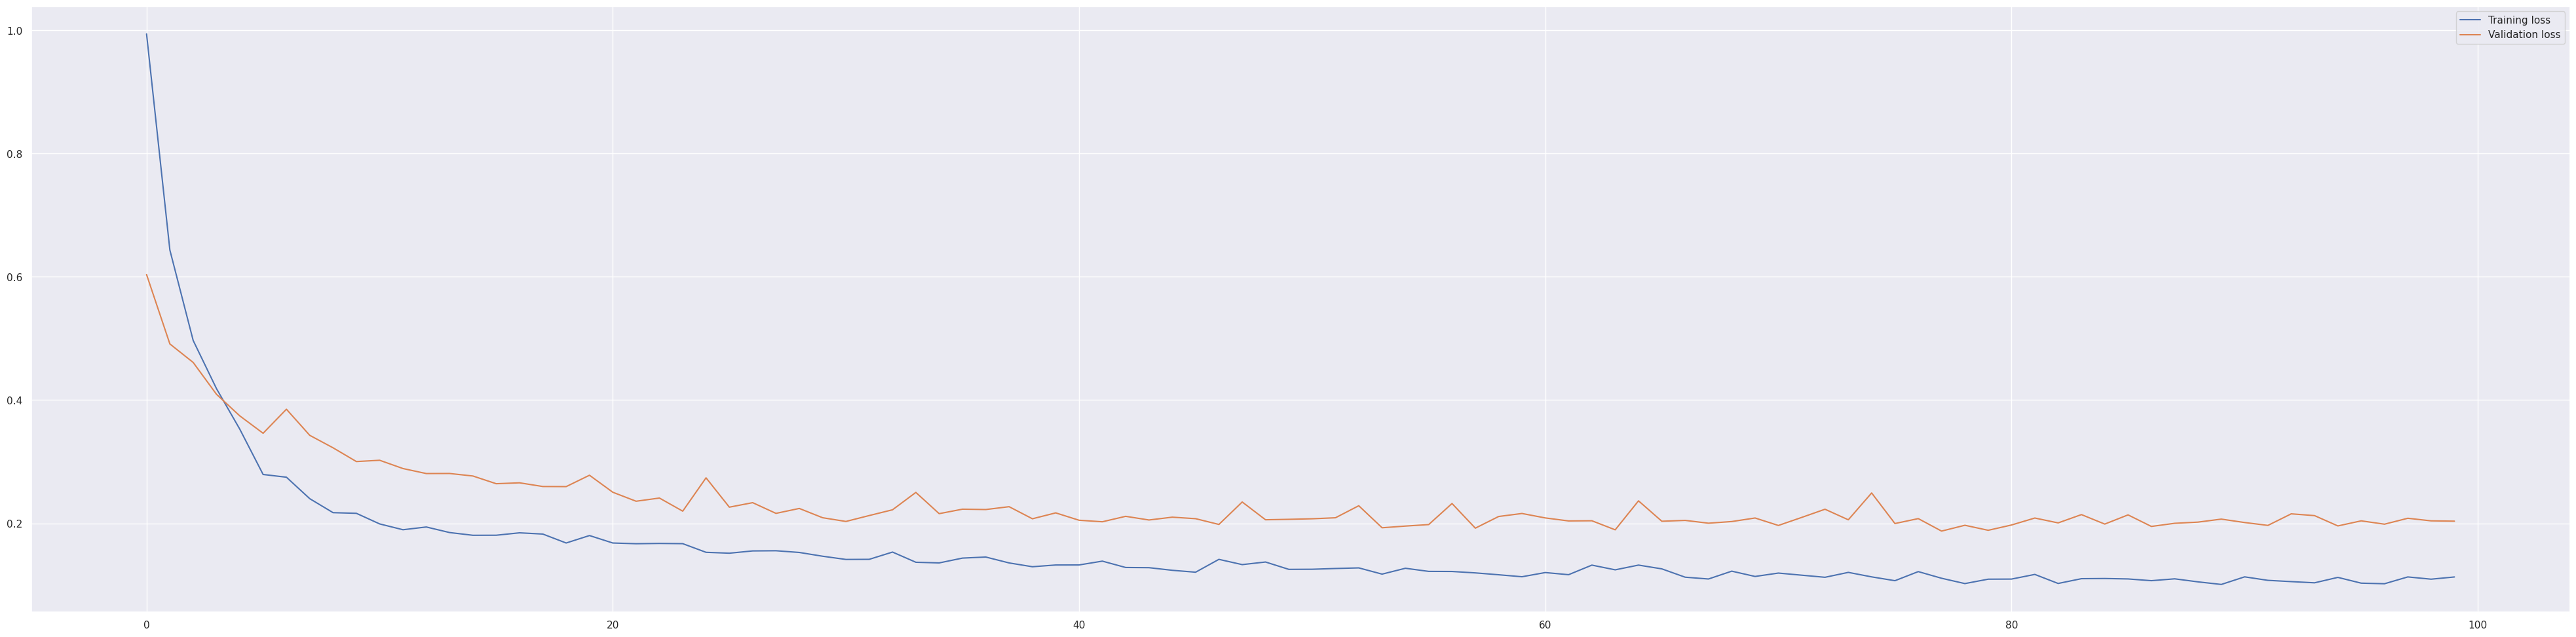

In [300]:
#Plot training and validation loss 

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [301]:
trainZ = []
for i in range(n_past, len(df_for_training_scaled) ):
    trainZ.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    

trainZ = np.array(trainZ)

print('trainZ shape == {}.'.format(trainZ.shape))

trainZ shape == (1343, 7, 10).


In [302]:
train_dates1 = pd.to_datetime(s3['date'])

n_days_for_prediction=1343  #last 30 days

predict_period_dates = pd.date_range(list(train_dates1[:-1342])[-1], periods=n_days_for_prediction).tolist()

In [303]:
df_for_training1 = s3[cols].tail(1350).astype(float)
dft1 = s3['date'].tail(24)

scaler1 = StandardScaler()
scaler1 = scaler1.fit(df_for_training1)
df_for_training_scaled1 = scaler1.transform(df_for_training1)

In [304]:
trainZ1 = []
pred=[]
for i in range(n_past, len(df_for_training_scaled1) ):
    pred.append(df_for_training_scaled1[i + n_future - 1:i + n_future, 0])
    trainZ1.append(df_for_training_scaled1[i - n_past:i, 0:df_for_training1.shape[1]])

trainZ1 = np.array(trainZ1)
pred = np.array(pred)

print('trainZ1 shape == {}.'.format(trainZ1.shape))
print('pred shape == {}.'.format(pred.shape))

trainZ1 shape == (1343, 7, 10).
pred shape == (1343, 1).


In [305]:
#Make predictions
prediction = model.predict(trainZ1[-n_days_for_prediction:]) 

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

42/42 [==============================] - 1s 4ms/step


In [306]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [307]:
# import seaborn as sns

    
# df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'sales':y_pred_future})
# df_forecast['date']=pd.to_datetime(df_forecast['date'])


# original = residuals1[['date', 'sales']]
# original['date']=pd.to_datetime(original['date'])
# original = original.loc[original['date'] >= '2013-01-08']

# sns.set(rc={"figure.figsize":(50, 16)})
# sns.lineplot(original, x='date', y='sales')
# sns.lineplot(df_forecast, x='date', y='sales')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


<AxesSubplot:xlabel='date', ylabel='sales'>

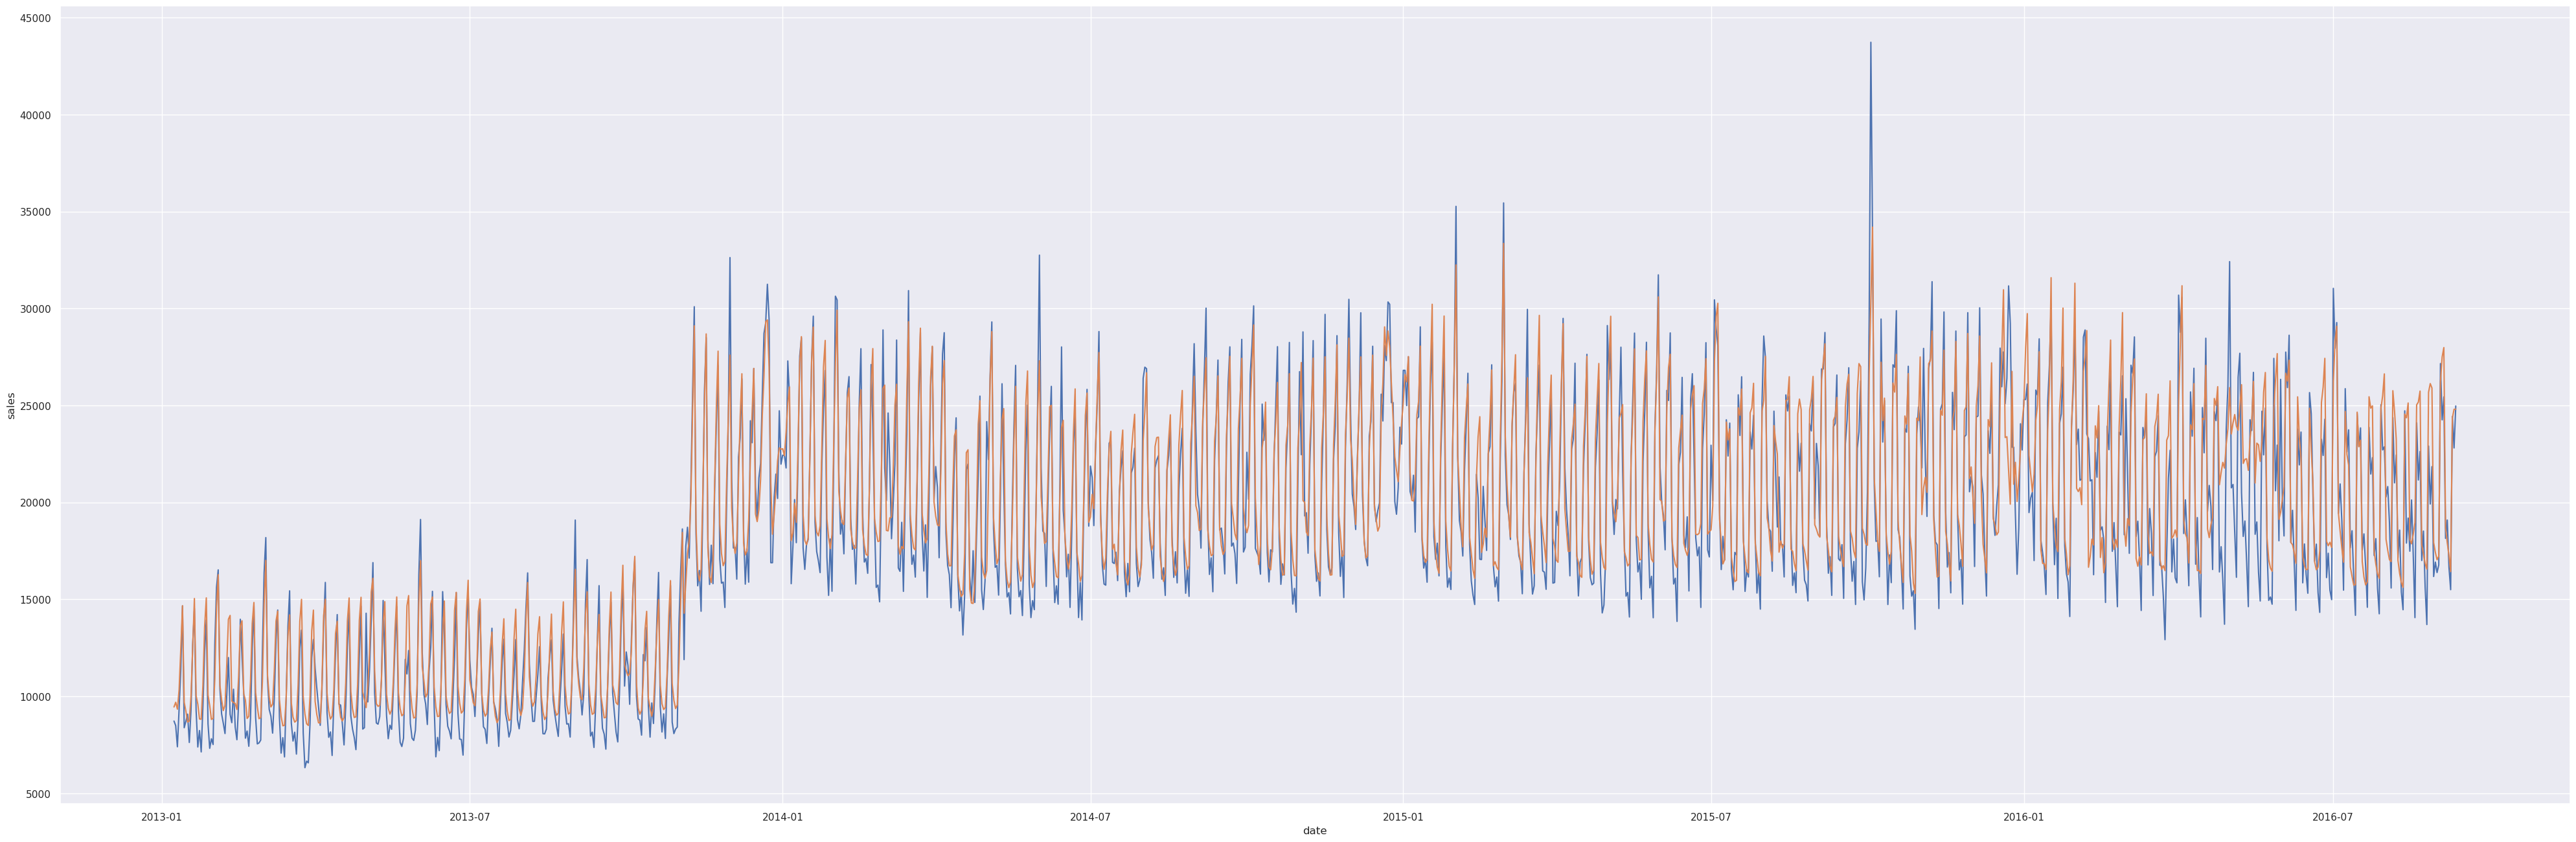

In [308]:
#Plot on train data predictions

import seaborn as sns

    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'sales':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = s3[['date', 'sales']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2013-01-08']

sns.set(rc={"figure.figsize":(50, 16)})
sns.lineplot(original, x='date', y='sales')
sns.lineplot(df_forecast, x='date', y='sales')

In [309]:
original.reset_index(inplace=True)
df_forecast.reset_index(inplace=True)

In [310]:
# plt.figure(figsize=(16,4))
# plt.plot(df_forecast['sales'])
# plt.legend()

In [311]:
lstmresiduals=original['sales'] - df_forecast['sales']

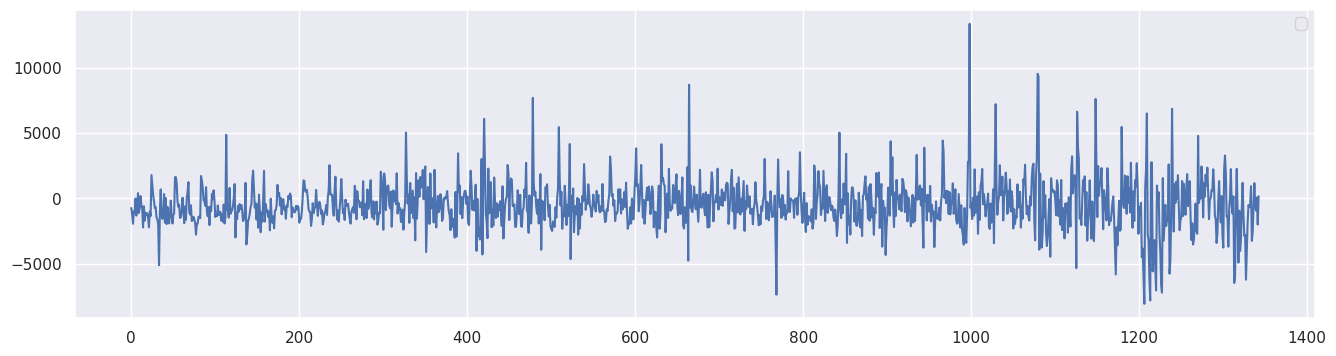

In [312]:
plt.figure(figsize=(16,4))
plt.plot(lstmresiduals)
plt.legend()

In [313]:
lstmresidualsquared=np.square(lstmresiduals)
rmseror=np.sqrt(np.sum(lstmresidualsquared)/1343)
rmseror

1861.0994818653862

In [314]:
s4

date         sales  onpromotion  national_holiday_type  dayofweek  \
0   2016-09-12  16167.302992            0                      0          0   
1   2016-09-13  14840.499920            0                      0          1   
2   2016-09-14  14646.700994            1                      0          2   
3   2016-09-15  14658.210000            0                      0          3   
4   2016-09-16  28385.163000         1288                      0          4   
..         ...           ...          ...                    ...        ...   
333 2017-08-11  25318.297990         1480                      5          4   
334 2017-08-12  19134.510058            6                      0          5   
335 2017-08-13  20509.265004           10                      0          6   
336 2017-08-14  18597.508060            7                      0          0   
337 2017-08-15  17586.709986            6                      0          1   

     quarter  month  year  dayofyear  dcoilwtico    residuals  
0          3      9  2016        256       46.28  8099.384132  
1          3      9  2016        257       44.91 -1944.143900  
2          3      9  2016        258       43.62 -5683.314011  
3          3      9  2016        259       43.85 -2748.576346  
4          3      9  2016        260       43.04  -769.669652  
..       ...    ...   ...        ...         ...          ...  
333        3      8  2017        223       48.81  2170.790102  
334        3      8  2017        224       47.59  3954.637335  
335        3      8  2017        225       47.59 -2356.973909  
336        3      8  2017        226       47.59 -2666.321012  
337        3      8  2017        227       47.57 -1171.015497  

[338 rows x 11 columns]

In [315]:
train_dates1 = pd.to_datetime(s4['date'])
print(train_dates1)

0     2016-09-12
1     2016-09-13
2     2016-09-14
3     2016-09-15
4     2016-09-16
         ...    
333   2017-08-11
334   2017-08-12
335   2017-08-13
336   2017-08-14
337   2017-08-15
Name: date, Length: 338, dtype: datetime64[ns]


In [316]:
n_days_for_prediction=331  #last 30 days

predict_period_dates = pd.date_range(list(train_dates1[:-330])[-1], periods=n_days_for_prediction).tolist()
# print(predict_period_dates)

In [317]:
df_for_training1 = s4[cols].tail(338).astype(float)

In [318]:
dft1 = s4['date'].tail(24)
# dft1

In [319]:
#normalize
scaler1 = StandardScaler()
scaler1 = scaler1.fit(df_for_training1)
df_for_training_scaled1 = scaler1.transform(df_for_training1)

In [320]:
trainZ1 = []
pred=[]
for i in range(n_past, len(df_for_training_scaled1) ):
    pred.append(df_for_training_scaled1[i + n_future - 1:i + n_future, 0])
    trainZ1.append(df_for_training_scaled1[i - n_past:i, 0:df_for_training1.shape[1]])

trainZ1 = np.array(trainZ1)
pred = np.array(pred)

print('trainZ1 shape == {}.'.format(trainZ1.shape))
print('pred shape == {}.'.format(pred.shape))



trainZ1 shape == (331, 7, 10).
pred shape == (331, 1).


In [321]:
#Make predictions
prediction = model.predict(trainZ1[-n_days_for_prediction:]) 

prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

11/11 [==============================] - 0s 4ms/step


In [322]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
# forecast_dates

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


<AxesSubplot:xlabel='date', ylabel='sales'>

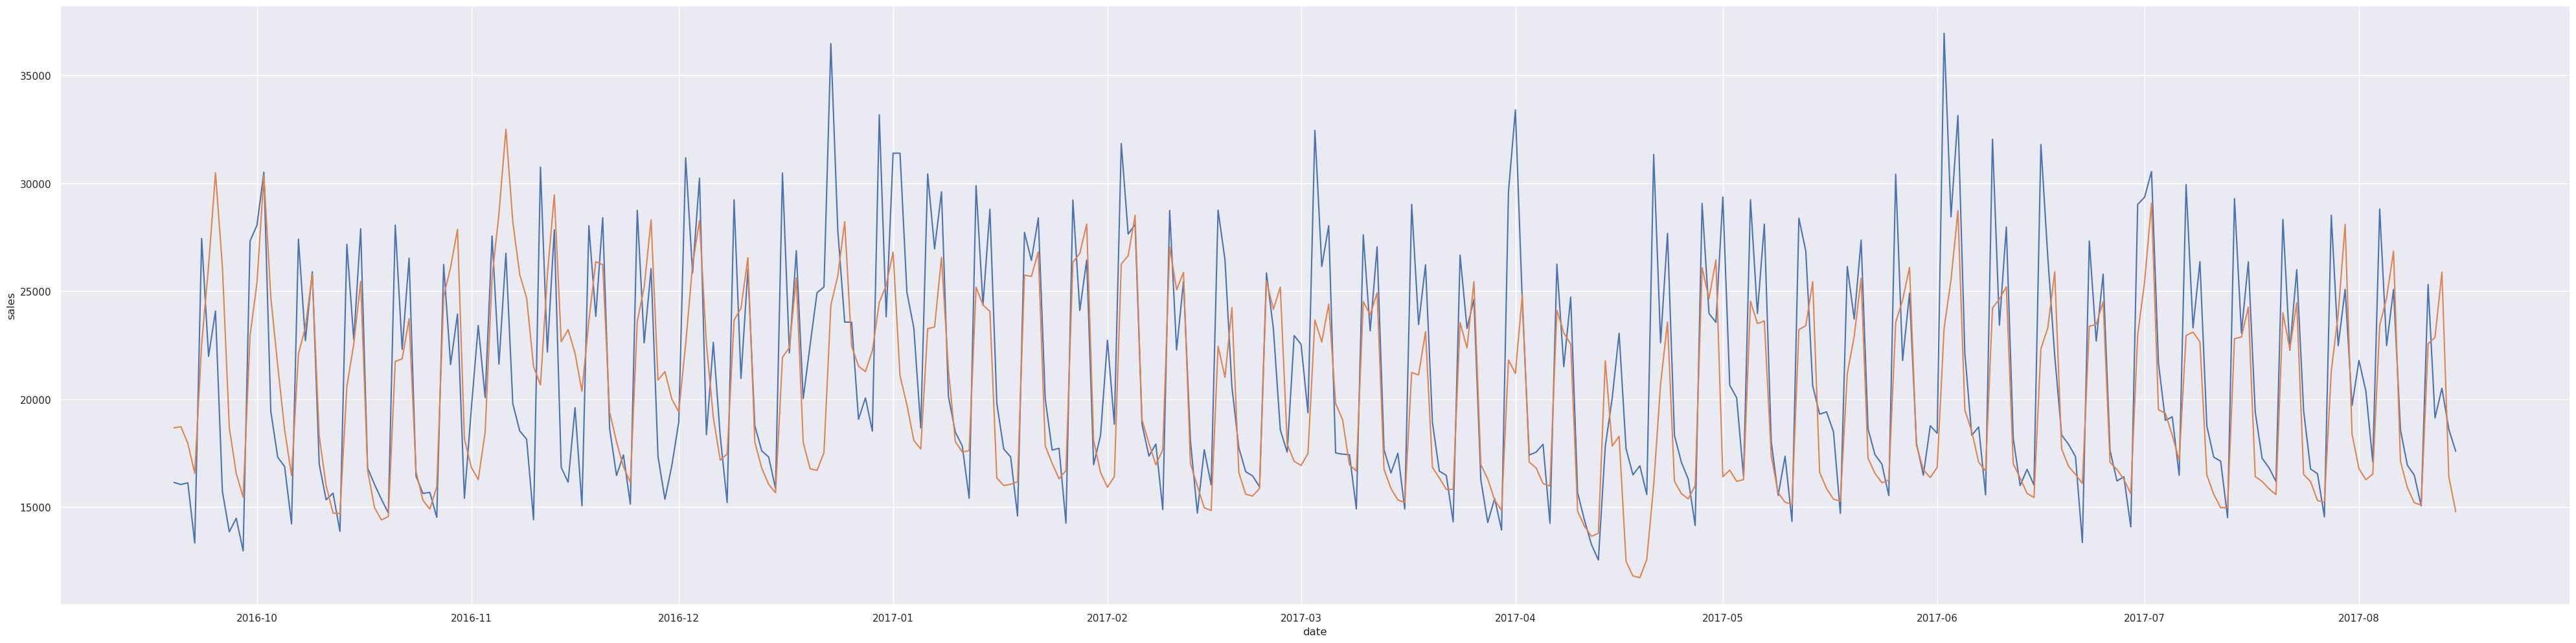

In [323]:
#Test data predictions plot

import seaborn as sns

    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'sales':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = s4[['date', 'sales']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2016-09-19']

sns.set(rc={"figure.figsize":(50, 12)})
sns.lineplot(original, x='date', y='sales')
sns.lineplot(df_forecast, x='date', y='sales')

In [324]:
original.reset_index(inplace=True)
df_forecast.reset_index(inplace=True)
lstmresiduals=original['sales'] - df_forecast['sales']

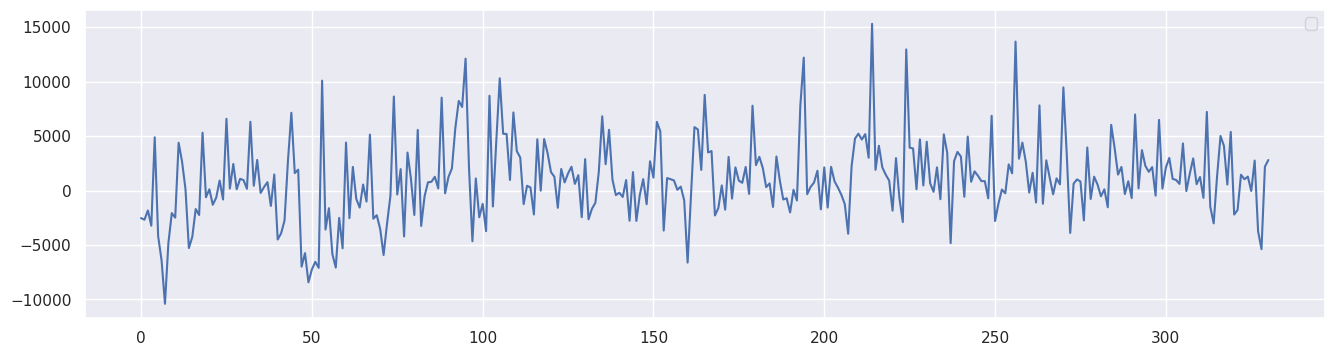

In [325]:
plt.figure(figsize=(16,4))
plt.plot(lstmresiduals)
plt.legend()

In [326]:
#RMSE on test data, improvement over SARIMA and LSTM standalone models
lstmresidualsquared=np.square(lstmresiduals)
rmseror=np.sqrt(np.sum(lstmresidualsquared)/331)
rmseror

3804.769014253311

In [327]:
#RMSLE
from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error( original['sales'], df_forecast['sales'] ))
rmsle

0.1685718546377514

In [295]:
# a = 1
# b = 1
# predictions_final = (a*predictions_test['sa'] + b*df_forecast['sales'])/(a+b)

In [296]:
df_forecast['sales']

0      20873.027344
1      21067.189453
2      19578.025391
3      17798.734375
4      23730.603516
           ...     
326    21432.962891
327    21679.376953
328    24985.023438
329    17499.777344
330    16337.292969
Name: sales, Length: 331, dtype: float32

In [297]:
predictions_test1 = pd.DataFrame(predictions_test)
# predictions_test1.reset_index()
# predictions_test1.rename(columns={'index': 'date'}, inplace=True)
predictions_test1.reset_index()

index  predicted_mean
0   2016-09-12    17765.537230
1   2016-09-13    18550.868980
2   2016-09-14    16113.895620
3   2016-09-15    14168.278382
4   2016-09-16    23582.033375
..         ...             ...
333 2017-08-11    23396.610487
334 2017-08-12    19815.099817
335 2017-08-13    21178.166785
336 2017-08-14    14500.705779
337 2017-08-15    15617.009818

[338 rows x 2 columns]

In [ ]:
plt.figure(figsize=(50,12))
plt.plot(s4['sales'], label="Actual")
plt.plot(predictions_final, label="Predicted")
plt.title('Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()